In [1]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("final_train_data.csv",  low_memory=False)
df.head()

,isic_id,target,patient_id,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity,anatom_site_general_nan,tbp_tile_type_3D: XP,tbp_tile_type_3D: white
0,ISIC_0015670,0,IP_1235828,60.0,1.0,3.04,20.244422,16.261975,26.922447,23.954773,...,0,0,0,0,1,0,0,0,0,1
1,ISIC_0015845,0,IP_8170065,60.0,1.0,1.10,31.712570,25.364740,26.331000,24.549290,...,0,0,0,1,0,0,0,0,0,1
2,ISIC_0015864,0,IP_6724798,60.0,1.0,3.40,22.575830,17.128170,37.970460,33.485410,...,0,0,0,0,0,1,0,0,1,0
3,ISIC_0015902,0,IP_4111386,65.0,1.0,3.22,14.242329,12.164757,21.448144,21.121356,...,1,0,1,0,0,0,0,0,1,0
4,ISIC_0024200,0,IP_8313778,55.0,1.0,2.73,24.725520,20.057470,26.464900,25.710460,...,1,0,1,0,0,0,0,0,0,1


In [ ]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype('category')

df.info()

In [ ]:
print(df[df.select_dtypes(include=['category']).columns])

# Catboost

In [ ]:
# %pip install catboost

In [4]:
# Function to plot training and validation metrics live
def plot_live(train_losses, val_losses, val_f1s, val_roc_aucs):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 3, 2)
    # plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Validation F1')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plot ROC-AUC
    plt.subplot(1, 3, 3)
    plt.plot(val_roc_aucs, label='Validation AUC-ROC')
    plt.title('AUC-ROC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.show()

In [4]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# Separate features, labels, and groups
X = df.drop(columns=['target', 'patient_id', "isic_id"])  # Metadata features
y = df['target']  # Labels (targets)
groups = df['patient_id']  # Group by patient ID
cat_features = ["lesion_id", "iddx_full", "iddx_1", "iddx_2", "iddx_3", "iddx_4", "mel_mitotic_index"]


### Train catboost

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)  # Stratified split to maintain class balance
print(f'train size: {X_train.shape}, val size: {Y_train.shape}')
print(f'train size: {X_val.shape}, val size: {Y_val.shape}')

train size: (320847, 97), val size: (320847,)
train size: (80212, 97), val size: (80212,)


In [7]:
Y_train.value_counts()

target
0    320533
1       314
Name: count, dtype: int64

In [18]:
Y_val.value_counts()

target
0    80133
1       79
Name: count, dtype: int64

In [ ]:
# Convert all object columns to categorical type
X_train[X_train.select_dtypes(include=['object']).columns] = X_train.select_dtypes(include=['object']).astype('category')
X_val[X_val.select_dtypes(include=['object']).columns] = X_val.select_dtypes(include=['object']).astype('category')

model2 = CatBoostClassifier(verbose=100,
						iterations=1000,
						loss_function='Logloss',
						early_stopping_rounds=50,
						custom_metric=['AUC'])

model2.fit(X_train, Y_train,
		cat_features=cat_features,
		eval_set=(X_val, Y_val))

y_train = model2.predict(X_train)
y_val = model2.predict(X_val)


In [9]:
y_train = model2.predict(X_train)
y_val = model2.predict(X_val)

In [6]:
# Initialize StratifiedGroupKFold
k = 5  # Number of splits
skf = StratifiedGroupKFold(n_splits=k)

train_losses, val_losses, train_f1s, val_f1s, val_roc_aucs = [], [], [], [], []
train_accuracies, val_accuracies = [], [] 
# Initialize CatBoost Classifier
model = CatBoostClassifier(
        iterations=100,  # Adjust as needed
        max_depth=7,
        learning_rate=0.01,
        # min_data_in_leaf=24,
        eval_metric='Logloss',  # Main metric
        use_best_model=True,
        custom_metric=['F1', 'AUC'],  # Additional metrics
    )

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups)):
    print(f"Training fold {fold + 1}/{k}...")
    train_loss,val_loss, train_acc, val_acc, val_f1, val_auc= 0,0,0,0,0,0
    # Create train and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train = scaler.transform(X_train)
    # X_val = scaler.transform(X_val)
    # # Convert to CatBoost Pool
    train_pool = Pool(X_train, y_train, cat_features= cat_features)
    val_pool = Pool(X_val, y_val,cat_features= cat_features)
    
    # Train the model
    model.fit(train_pool,
              eval_set=val_pool, 
              verbose=False, 
              plot=True)
    
    # Predict on train and validation sets
    # train_preds = model.predict_proba(X_train)[:, 1]
    # val_preds = model.predict_proba(X_val)[:, 1]
    train_preds_proba = model.predict_proba(X_train)[:, 1]
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    train_preds = (train_preds_proba >= 0.5).astype(int)
    val_preds = (val_preds_proba >= 0.5).astype(int) 
    
    # Calculate training and validation loss (log loss)
    train_loss = log_loss(y_train, train_preds_proba)
    val_loss = log_loss(y_val, val_preds_proba)
    # train_loss = model.get_best_score()['learn']['Logloss']
    # val_loss = model.get_best_score()['validation']['Logloss']
    train_f1 = f1_score(y_train, train_preds)
    val_f1 = f1_score(y_val, val_preds)
    train_auc = roc_auc_score(y_train, train_preds_proba)
    val_auc = roc_auc_score(y_val, val_preds_proba)
    
    # Calculate training and validation accuracy
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    val_roc_aucs.append(val_auc)

    print(f"Fold {fold + 1}/{k}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")
    
    # Plot live metrics
    # plot_live(train_losses, val_losses, val_f1s, val_roc_aucs)

# Final evaluation on all folds
print(f"Average Train Loss: {np.mean(train_losses):.4f}, Average Validation Loss: {np.mean(val_losses):.4f}")
print(f"Average Train Accuracy: {np.mean(train_accuracies):.4f}, Average Validation Accuracy: {np.mean(val_accuracies):.4f}")

Training fold 1/5...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 1/5, Train Loss: 0.0007, Val Loss: 0.0007, Train Accuracy: 1.0000, Val Accuracy: 1.0000
Training fold 2/5...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 2/5, Train Loss: 0.0008, Val Loss: 0.0008, Train Accuracy: 1.0000, Val Accuracy: 1.0000
Training fold 3/5...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 3/5, Train Loss: 0.0007, Val Loss: 0.0007, Train Accuracy: 1.0000, Val Accuracy: 1.0000
Training fold 4/5...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 4/5, Train Loss: 0.0007, Val Loss: 0.0007, Train Accuracy: 1.0000, Val Accuracy: 1.0000
Training fold 5/5...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 5/5, Train Loss: 0.0008, Val Loss: 0.0008, Train Accuracy: 1.0000, Val Accuracy: 1.0000
Average Train Loss: 0.0007, Average Validation Loss: 0.0007
Average Train Accuracy: 1.0000, Average Validation Accuracy: 1.0000


In [7]:
model.save_model('catboost_model.cbm')
# model.load_model("notebooks/catboost_model.cbm")

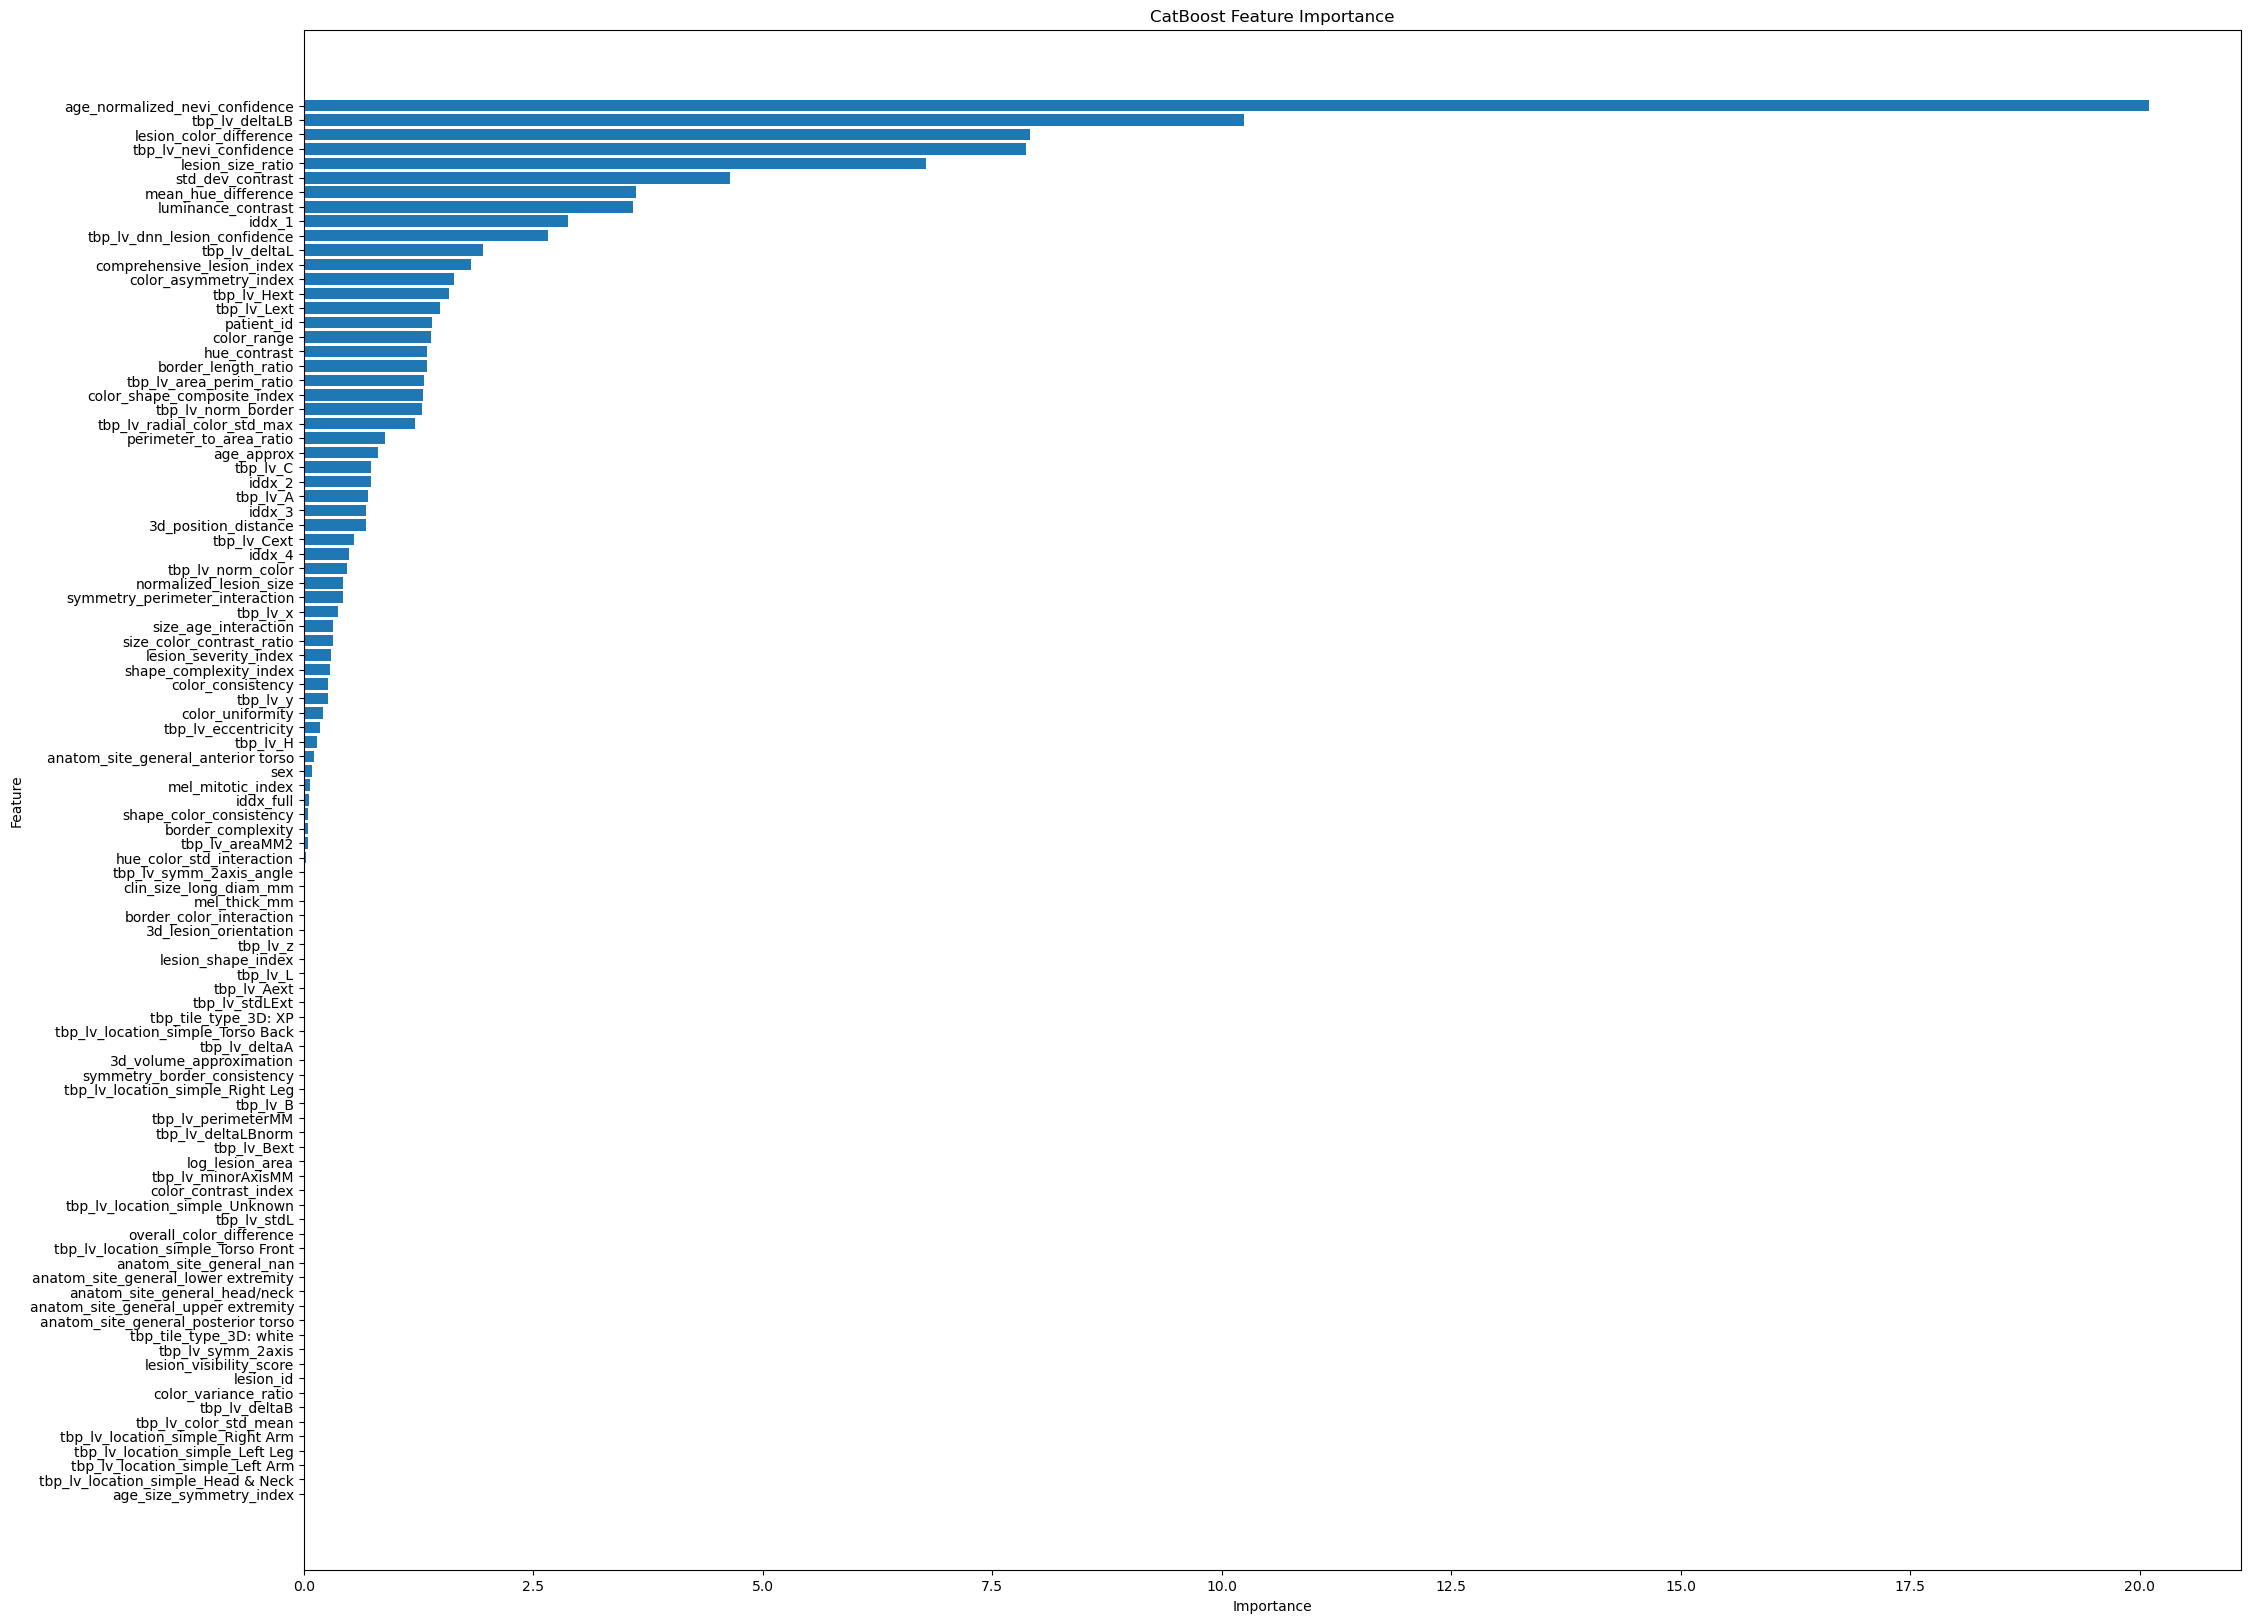

In [12]:
import catboost
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a trained CatBoost model
# model = catboost.CatBoostClassifier()
# model.fit(X_train, y_train)

# Get feature importance
feature_importance = model2.get_feature_importance()
features = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(25, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
